

<h1><center><strong>Checking Imbalance and Balancing</strong></center></h1>

# **Table of Contents**

1. [Checking for Assumptions (Imbalance)](#Section1)<br><br>
2. [Treating Assumption Violation (Balancing)](#Section2)<br><br>
  
  2.1 [Resampling](#Section201)<br><br> 
    
    - 2.1.1 [Random Oversampling](#Section20101)<br><br> 
    
    - 2.1.2 [Random Undersampling](#Section20102)<br><br>
    
    - 2.1.3 [Combining Oversampling and Undersampling](#Section20103)<br><br>

  2.2 [Generating Synthetic Samples using SMOTE](#Section202)<br><br>

    - 2.2.1 [Oversampling using SMOTE](#Section20201)<br><br>

    - 2.2.2 [SMOTE for Classification](#Section20202)<br><br>

  2.3 [Cluster Centroid Undersampling](#Section203)<br><br>


<a id = Section1></a>
## **1. Checking for Assumptions (Imbalance)**

- **Imbalanced classes** are a common problem in machine learning classification where there are a **disproportionate ratio** of **observations** in **each class**.

- Class imbalance can be found in many different areas including medical diagnosis, spam filtering, and fraud detection.

- **Causes** of Class Imbalance:
  
  - **Biased Sampling**

  - **Measurement Errors**

- Most machine learning algorithms **work best** when the **number of samples** in **each class** are about **equal**.

- This is because most algorithms are designed to **maximize accuracy** and **reduce error**.

- Also, while working in an **imbalanced domain accuracy** is **not** an **appropriate measure** to evaluate model performance.


#### **Creating a Dummy Dataset**

- First, we can use the `make_classification` **scikit-learn** function to create a synthetic binary classification dataset with **10,000 examples** and a **1:100 class distribution**.

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
# Define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

- We can use the **Counter** object to summarize the **number of examples** in **each class** to confirm the dataset was created correctly.

In [ ]:
# Summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


- Finally, we can create a **scatter plot** of the dataset and **color** the examples for **each class** a **different color** to clearly see the spatial nature of the **class imbalance**.

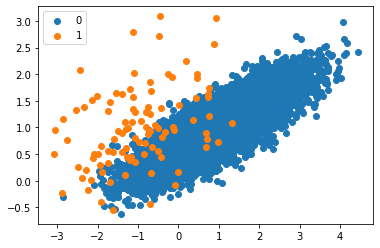

In [ ]:
# Scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

**Observations:**

- Running the code first summarizes the class distribution, confirms the **1:100 ratio**, in this case with about **9,900 examples** in the **majority** class and **100** in the **minority** class.

- A **scatter plot** of the dataset is created showing the **large mass** of points that belong to the **minority** class (**blue**) and a **small number** of points spread out for the **minority** class (**orange**).

- We can see some measure of **overlap** between the **two classes**.

#### **Evaluating a ML model on Imbalanced Dataset**

- Only adding a **Decision Tree** to the pipeline.

In [ ]:
# Define pipeline
steps = [('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

- Performing **10-fold** cross-validation on the dataset, setting **accuracy** as the performance metric.

In [ ]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('Accuracy: %.3f' % score)

Accuracy: 0.991


- We get an **accuracy** of **99.1%** after performing 10-fold cross-validation on a Decision Tree model.

- But, since our dataset contains **99% samples** belonging to **1 class**, and if our **model predicts all** the **samples** as the **majority class**, we will get an **accuracy** of **99%**.

- Therefore, this can't be considered a good model at all, and we need to **balance** our **dataset** in order to train an effective model on it. 

<a id = Section2></a>
## **2. Treating Assumption Violation (Balancing)**

- **Tactics** to **Combat** Imbalanced Training data:

  - **Collect more data**, if possible.

  - Try **changing** the **performance metric**.

  - Try **resampling** the dataset.

  - Try **generating synthetic samples**.

- We will use **imbalanced-learn** library to balance our imbalanced datasets.

- To **install** imbalanced-learn, run this command:

In [ ]:
!pip install imbalanced-learn

- To **update** the existing imbalanced-learn version to its latest state, use this command.

In [ ]:
!pip install --upgrade imbalanced-learn

     |████████████████████████████████| 163kB 2.7MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


**Note:** You need to restart the kernel after installing or updating the library in order to use it.

<a id = Section201></a>
### **2.1 Resampling**

- **Resampling** involves **creating** a **new transformed version** of the training dataset in which the selected examples have a **different class distribution**.

- This is a **simple** and **effective** strategy for imbalanced classification problems.

<br> 

- The simplest strategy is to **choose examples** for the transformed dataset **randomly**, called **random resampling**.

- There are **two** main **approaches** to random resampling for imbalanced classification:

  - **Random Oversampling**: Randomly **duplicate** examples in the **minority** class.

  - **Random Undersampling**: Randomly **delete** examples in the **majority** class.

- Both approaches can be **repeated** until the **desired class distribution** is achieved in the training dataset, such as an equal split across the classes.

- They are referred to as **“naive resampling”** methods because they **assume nothing** about the data and no heuristics are used.

- This makes them **simple to implement** and **fast to execute**, which is desirable for very large and complex datasets.

- Both techniques can be used for **two-class** (binary) classification problems and **multi-class** classification problems with one or more majority or minority classes.

- Importantly, the **change** to the class distribution is only **applied** to the **training dataset**.

  - The intent is to **influence** the **fit** of the models.
  
  - The resampling is **not applied** to the **test** or **holdout** dataset used to **evaluate** the performance of a model.

<a id = Section20101></a>
#### **2.1.1 Random Oversampling**

- **Random oversamplin**g involves **randomly selecting examples** from the **minority** class, **with replacement**, and **adding** them to the **training** dataset.

- Examples from the training dataset are selected **randomly with replacement**.

  - This means that **examples** from the minority class can be **chosen** and **added** to the new “more balanced” training dataset **multiple times**.
  
  - They are **selected** from the original training dataset, **added** to the new training dataset, and then **returned** or “replaced” in the original dataset, allowing them to be **selected again.**

<br> 

- This technique can be **effective** for those machine learning algorithms that are affected by a **skewed distribution** and where **multiple duplicate examples** for a given class can **influence** the **fit** of the model.

  - This might include algorithms that **iteratively learn coefficients**, like **artificial neural networks** that use stochastic gradient descent.
  
  - It can also affect models that **seek good splits of** the **data**, such as **support vector machines** and **decision trees**.

<br> 

- In some cases, seeking a balanced distribution for a severely imbalanced dataset can cause affected algorithms to **overfit** the **minority** class, leading to **increased generalization error**.

  - The effect can be **better performance on** the **training** dataset, but **worse performance** on the **holdout** or **test** dataset.


In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

- Random oversampling can be implemented using the **RandomOverSampler** class.

- It takes a `sampling_strategy` argument that can be set to **“minority”** to automatically **balance** the **minority** class with majority class or classes.

- This means that if the **majority** class had **1,000** examples and the **minority** class had **100**, this strategy would **oversampling** the **minority** class so that it has **1,000 examples**.

- The class is like a scikit-learn transform object such that it is **fit** on a dataset, and then used to **generate** a new or transformed dataset.

- Unlike the scikit-learn transforms, it will **change** the **number of examples** in the dataset, not just the values (like a scaler) or number of features (like a projection).

- It can be **fit and applied** in one step by calling the `fit_sample()` function.

In [ ]:
# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

In [ ]:
# Fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

In [ ]:
# Summarize original class distribution
print(Counter(y))

Counter({0: 9900, 1: 100})


In [ ]:
# Summarize class distribution
print(Counter(y_over))

Counter({0: 9900, 1: 9900})


- The original dataset had 9900 samples in the majority class and 100 samples in the minority class.

- But, after the **Random Oversample** transform is **fitted** and **applied** to the dataset.

  - The class distribution for the transformed dataset is showing that the **minority** class has the **same** number of **examples** as the **majority** class.

#### **Creating a ML Pipeline with Random Oversampling**

- Our pipeline will first perform **Random Oversampling** on the dataset, followed by a **Decision Tree Classifier**.

- Performing **10-fold cross-validation** on the dataset.

- We are using **F1 score** as the evaluation **metric** for more robust results.

In [ ]:
# Define pipeline
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [ ]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.991


- We get a **F1 score** of **99.1%** after performing Random Oversampling and classification using Decision Tree Classifier.

- The **results** might **vary slightly** every time this code is run, due to the **random nature** of the algorithm.

<a id = Section20102></a>
#### **2.1.2 Random Undersampling**

- Random undersampling involves **randomly selecting examples** from the **majority** class and **deleting** them from the training dataset.

- This has the effect of **reducing** the **number** of **examples** in the **majority** class in the transformed version of the training dataset.

<br>

- This approach may be more **suitable** for those datasets where there is a **class imbalance** although a **sufficient** number of **examples** in the **minority** class.

<br>

- A **limitation** of undersampling is that **examples** from the majority class are **deleted** that may be **useful**, **important**, or perhaps **critical** to fitting a **robust decision boundary**.

  - Given that examples are deleted randomly, there is no way to detect or preserve “good” or more information-rich examples from the majority class.

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

- The random undersampling technique can be implemented using the **RandomUnderSampler** imbalanced-learn class.

- Setting the `sampling_strategy` argument to **“majority”** will **undersample** the **majority** class determined by the class with the largest number of examples.

- For example, a dataset with **1,000 examples** in the **majority** class and **100** examples in the **minority** class will be **undersampled** such that **both classes** would have **100 examples** in the transformed training dataset.

In [ ]:
# Define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
# Fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

In [ ]:
# Summarize original class distribution
print(Counter(y))

Counter({0: 9900, 1: 100})


In [ ]:
# Summarize class distribution
print(Counter(y_under))

Counter({0: 100, 1: 100})


- The original dataset had 9900 samples in the majority class and 100 samples in the minority class.

- But, after the **Random Undersample** transform is **fitted** and **applied** to the dataset.

  - We can see that that **majority** class is **undersampled** to have the **same** number of **examples** as the **minority** class.

#### **Creating a ML Pipeline with Random Underampling**

- Our pipeline will first perform **Random Undersampling** on the dataset, followed by a **Decision Tree Classifier**.

In [ ]:
# Define pipeline
steps = [('under', RandomUnderSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [ ]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.851


- We get a **F1 score** of **85.1%** after performing Random Underampling and classification using Decision Tree Classifier.

- The **results** might **vary slightly** every time this code is run, due to the **random nature** of the algorithm.

- These results are **worse** when compared with Random Oversampling results.

<a id = Section20103></a>
#### **2.1.3 Combining Oversampling and Undersampling**

- Interesting results may be achieved by **combining** both **random oversampling** and **undersampling**.

- For example, a **modest** amount of **oversampling** can be applied to the **minority** class to **improve** the **bias** towards these examples, whilst also applying a **modest** amount of **undersampling** to the **majority** class to **reduce** the **bias** on that class.

- This can result in **improved overall performance** compared to performing one or the other techniques in isolation.

- For example, if we had a dataset with a **1:100 class distribution**, we might first apply **oversampling** to **increase** the ratio to **1:10** by **duplicating** examples from the **minority** class, then apply **undersampling** to further **improve** the ratio to **1:2** by **deleting** examples from the **majority** class.

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Summarize original class distribution
print(Counter(y))

Counter({0: 9900, 1: 100})


- Originally, the **majority** class has **9900** samples, and the **minority** class has **100** samples.

- This could be implemented using imbalanced-learn by using:

  - A **RandomOverSampler** with `sampling_strategy` set to **0.1** (**10%**), then
  
  - A **RandomUnderSampler** with a `sampling_strategy` set to **0.5** (**50%**).

**Applying Random Oversampling**

In [ ]:
# Define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1)

In [ ]:
# Fit and apply the transform
X_new, y_new = over.fit_resample(X, y)

In [ ]:
# Summarize class distribution
print(Counter(y_new))

Counter({0: 9900, 1: 990})


- The **majority** class now has **9900** samples, and the **minority** class has **990** samples, giving a **ratio** of **1:10**

**Applying Random Undersampling**

In [ ]:
# Define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)

In [ ]:
# Fit and apply the transform
X_new, y_new = under.fit_resample(X_new, y_new)

In [ ]:
# Summarize class distribution
print(Counter(y_new))

Counter({0: 1980, 1: 990})


- The **majority** class now has **1980** samples, and the **minority** class has **990** samples, giving a **ratio** of **1:2**

#### **Creating a ML Pipeline with Random Oversampling and Undersampling**

- Our pipeline will first perform **Random Oversampling** on the dataset, and then **Random Undersampling**, followed by a **Decision Tree Classifier**.

In [ ]:
# Define pipeline
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('m', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [ ]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.982


- We get a **F1 score** of **98.2%** after performing both Random Oversampling and Underampling, and then classification using Decision Tree Classifier.

- The **results** might **vary slightly** every time this code is run, due to the **random nature** of the algorithm.

- These results are way **better** when compared with Random Undersampling results, but still a little lower than Random Oversampling results.

- This might not be the case for other real-world datasets, and we might achieve better results than Random Oversampling as well.

- Always **experiment** with **different Resampling techniques** and compare the results before finalizing a method.

<a id = Section202></a>
### **2.2 Generating Synthetic Samples using SMOTE**

- An **improvement** on **duplicating** examples from the **minority** class is to **synthesize new examples** from the **minority** class.

- This is a type of **data augmentation** for **tabular data** and can be very **effective**.

- Perhaps the **most** widely used approach to synthesizing new examples is called the **Synthetic Minority Oversampling TEchnique**, or **SMOTE** for short.

<a id = Section20201></a>
#### **2.2.1 Oversampling using SMOTE**

- SMOTE works by **selecting examples** that are **close** in the **feature space**, **drawing** a **line** between the examples in the feature space and **drawing** a **new sample** at a **point along** that **line**.

  - Specifically, a **random** example from the **minority** class is first chosen.

  - Then **k** of the **nearest neighbors** for that example are **found** (typically k=5).
  
  - A **randomly selected neighbor** is chosen and a **synthetic** example is **created** at a **randomly selected point** between the two examples in feature space.

- This procedure can be used to **create** as many **synthetic** examples for the **minority** class as are required.

<br> 

- It is suggested, to first **using random undersampling trim** the number of **examples** in the **majority** class, then **use SMOTE** to **oversample** the **minority** class to balance the class distribution.

  - The approach is **effective** because **new synthetic examples** from the minority class are created that are **plausible**, that is, are relatively **close in feature spac**e to existing examples from the **minority** class.

<br> 

- A general **downside** of the approach is that **synthetic** examples are created **without considering** the **majority** class, possibly **resulting** in **ambiguous** examples if there is a **strong overlap** for the classes.

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Summarize original class distribution
print(Counter(y))

Counter({0: 9900, 1: 100})


- We can use the SMOTE implementation provided by the imbalanced-learn Python library in the **SMOTE** class.

- We will **define** a **SMOTE** instance with default parameters that will **balance** the **minority** class.

- And then **fit** and **apply** it in one step to create a **transformed** version of our dataset.

In [ ]:
# Transform the dataset
oversample = SMOTE()
X_new, y_new = oversample.fit_resample(X, y)

In [ ]:
# Summarize the new class distribution
counter = Counter(y_new)
print(counter)

Counter({0: 9900, 1: 9900})


- The transformed dataset has a **balanced** distribution now with **9,900** examples in **both** the **classes**.

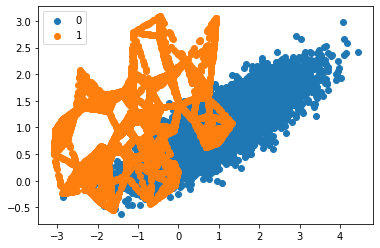

In [ ]:
# Scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_new == label)[0]
	plt.scatter(X_new[row_ix, 0], X_new[row_ix, 1], label=str(label))
plt.legend()
plt.show()

- The scatter plot shows **many more example**s in the **minority** class **created** along the lines **between** the **original** examples in the minority class.

#### **Creating a Pipeline with SMOTE and Random Undersampling**

- Our pipeline will first perform **Oversampling** using **SMOTE** on the dataset, and then **Random Undersampling**.

In [ ]:
# Define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [ ]:
# Transform the dataset
X_new, y_new = pipeline.fit_resample(X, y)

In [ ]:
# Summarize the new class distribution
counter = Counter(y_new)
print(counter)

Counter({0: 1980, 1: 990})


- The **majority** class now has **1980** samples, and the **minority** class has **990** samples, giving a **ratio** of **1:2**

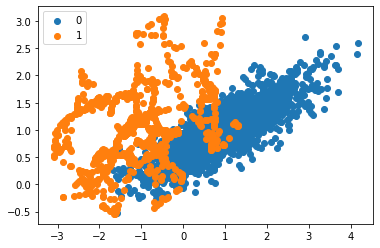

In [ ]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_new == label)[0]
	plt.scatter(X_new[row_ix, 0], X_new[row_ix, 1], label=str(label))
plt.legend()
plt.show()

<a id = Section20202></a>
#### **2.2.2 SMOTE for Classification**

#### **Creating a ML Pipeline with SMOTE**

- Our pipeline will first perform **Oversampling** using **SMOTE** on the dataset, followed by a **Decision Tree Classifier**.

In [ ]:
# Define pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [ ]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
print('Mean F1 Score: %.3f' % np.mean(scores))

Mean F1 Score: 0.934


- We get a **F1 score** of **93.4%** after performing **Oversampling using SMOTE**, and then classification using Decision Tree Classifier.

- The **results** might **vary slightly** every time this code is run, due to the **random nature** of the algorithm.

#### **Creating a ML Pipeline with SMOTE and Random Undersampling**

- Our pipeline will first perform **Oversampling** using **SMOTE** on the dataset, and then **Random Undersampling**, followed by a **Decision Tree Classifier**.

In [ ]:
# Define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [ ]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
print('Mean F1 Score: %.3f' % np.mean(scores))

Mean F1 Score: 0.942


- We get a **F1 score** of **94.2%** after performing both Oversampling using SMOTE and Random Underampling, and then classification using Decision Tree Classifier.

- The **results** might **vary slightly** every time this code is run, due to the **random nature** of the algorithm.

- We are getting **better results** when **SMOTE** is **coupled** with **Random Undersampling**.

<a id = Section203></a>
### **2.3 Cluster Centroid Undersampling**

- In Cluster Centorid Undersampling, we perform **under-sampling** by **generating centroids** based on **clustering** methods.

- It **under samples** the **majority** class by **replacing** a **cluster** of **majority samples** by the **cluster centroid** of a **KMeans** algorithm.

- This algorithm **keeps N majority samples** by fitting the **KMeans** algorithm with **N cluster** to the majority class and using the **coordinates** of the **N cluster centroids** as the **new majority samples**.

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Summarize original class distribution
print(Counter(y))

Counter({0: 9900, 1: 100})


- We can implement this procedure using the **ClusterCentroids** class in the imbalanced-learn library.

In [ ]:
# Transform the dataset
undersample = ClusterCentroids(random_state=42)
X_new, y_new = undersample.fit_resample(X, y)

In [ ]:
# Summarize the new class distribution
counter = Counter(y_new)
print(counter)

Counter({0: 100, 1: 100})


- The class distribution is **balanced** after applying **Cluster Centroid** sampling into the dataset.

- The **majority** class is **undersampled** to have same number of samples as the minority class.

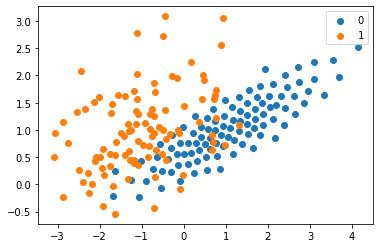

In [ ]:
# Scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_new == label)[0]
	plt.scatter(X_new[row_ix, 0], X_new[row_ix, 1], label=str(label))
plt.legend()
plt.show()

#### **Creating a ML Pipeline with Cluster Centroid Undersampling**

- Our pipeline will first perform **Cluster Centroid Undersampling** on the dataset, followed by a **Decision Tree Classifier**.

In [ ]:
# Define pipeline
steps = [('under', ClusterCentroids(random_state=42)), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [ ]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.888


- We get a **F1 score** of **88.8%** after performing Cluster Centroid Underampling and classification using Decision Tree Classifier.

- The **results** might **vary slightly** every time this code is run, due to the **random nature** of the algorithm.

- These results are much **better** than Random Undersampling, which had a **F1 score** of **85.1%**